[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eo-agh/data-analysis-earth-sciences/blob/main/docs/stac.ipynb)

## STAC

SpatioTemporal Asset Catalog (STAC) to otwarty standard służący do organizowania i przeszukiwania danych geoprzestrzennych, takich jak zobrazowania satelitarne, modele terenu czy dane LiDAR. STAC został zaprojektowany z myślą o efektywnym katalogowaniu zasobów przestrzennych, co pozwala na ich łatwe odkrywanie, filtrowanie i analizę. Dzięki STAC użytkownicy mogą szybko przeszukiwać ogromne zbiory danych, stosując kryteria takie jak lokalizacja, przedział czasowy, rozdzielczość czy dostępność pasm spektralnych. 

Najważniejsze zalety STAC:
- **Standaryzacja** – jednolity format umożliwia interoperacyjność między różnymi dostawcami danych.
- **Elastyczność** – możliwość rozszerzania schematów metadanych i dostosowywania ich do specyficznych potrzeb.
- **Łatwość przeszukiwania** – szybkie zapytania pozwalają na odnalezienie interesujących zobrazowań na podstawie obszaru i daty.
- **Integracja z chmurą** – wiele publicznych katalogów STAC dostępnych jest w chmurze, co ułatwia pracę z dużymi zbiorami danych.

Dzięki STAC eksploracja i analiza danych geoprzestrzennych staje się znacznie bardziej efektywna, co ma kluczowe znaczenie dla naukowców, analityków oraz firm zajmujących się obserwacją Ziemi.


### Przeszukanie kolekcji dostępnych w STAC w Planetary Computer

In [1]:
import pystac_client
import planetary_computer as pc
import rasterio
import numpy as np
import folium
from folium.raster_layers import ImageOverlay
import matplotlib.pyplot as plt
from PIL import Image
from rasterio.mask import mask
from rasterio.warp import transform_geom
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import io
import base64

In [2]:
# Połączenie z publicznym katalogiem STAC na Azure Planetary Computer
stac_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
stac_client = pystac_client.Client.open(stac_url)

# Lista dostępnych kolekcji
collections = stac_client.get_all_collections()
print("Dostępne kolekcje:")
for collection in collections:
    print(collection.id, "-", collection.title)

Dostępne kolekcje:
daymet-annual-pr - Daymet Annual Puerto Rico
daymet-daily-hi - Daymet Daily Hawaii
3dep-seamless - USGS 3DEP Seamless DEMs
3dep-lidar-dsm - USGS 3DEP Lidar Digital Surface Model
fia - Forest Inventory and Analysis
sentinel-1-rtc - Sentinel 1 Radiometrically Terrain Corrected (RTC)
gridmet - gridMET
daymet-annual-na - Daymet Annual North America
daymet-monthly-na - Daymet Monthly North America
daymet-annual-hi - Daymet Annual Hawaii
daymet-monthly-hi - Daymet Monthly Hawaii
daymet-monthly-pr - Daymet Monthly Puerto Rico
gnatsgo-tables - gNATSGO Soil Database - Tables
hgb - HGB: Harmonized Global Biomass for 2010
cop-dem-glo-30 - Copernicus DEM GLO-30
cop-dem-glo-90 - Copernicus DEM GLO-90
terraclimate - TerraClimate
nasa-nex-gddp-cmip6 - Earth Exchange Global Daily Downscaled Projections (NEX-GDDP-CMIP6)
gpm-imerg-hhr - GPM IMERG
gnatsgo-rasters - gNATSGO Soil Database - Rasters
3dep-lidar-hag - USGS 3DEP Lidar Height above Ground
io-lulc-annual-v02 - 10m Annual Land 

### Przeszukiwanie w czasie i przestrzeni

In [3]:
# Definiowanie obszaru zainteresowania i przedziału czasowego
aoi = {
    "type": "Polygon",
    "coordinates": [[
        [19.86, 50.02], [20.03, 50.02], [20.03, 50.12], [19.86, 50.12], [19.86, 50.02]
    ]]
}
time_range = "2023-06-01/2023-06-30"

# Wyszukiwanie danych Sentinel-2 spełniających kryteria
search = stac_client.search(
    collections=["sentinel-2-l2a"],
    intersects=aoi,
    datetime=time_range,
    max_items=5
)

items = list(search.items())
print(f"Znaleziono {len(items)} scen Sentinel-2")
print(f"Nazwy scen: {items}")


Znaleziono 5 scen Sentinel-2
Nazwy scen: [<Item id=S2B_MSIL2A_20230628T093549_R036_T34UDA_20240927T171423>, <Item id=S2B_MSIL2A_20230628T093549_R036_T34UDA_20230628T233107>, <Item id=S2A_MSIL2A_20230626T095031_R079_T34UDA_20241002T040319>, <Item id=S2A_MSIL2A_20230626T095031_R079_T34UDA_20230626T155031>, <Item id=S2A_MSIL2A_20230623T094031_R036_T34UDA_20241002T172545>]


### Przeprowadzanie obliczeń

In [4]:
item = items[0]
# Pobranie pasm B04 (czerwone) i B08 (NIR)
b04_asset = pc.sign(item.assets["B04"].href)
b08_asset = pc.sign(item.assets["B08"].href)

In [5]:
# Przycięcie zobrazowania do AOI
def clip_raster(dataset, aoi):
    from shapely.geometry import shape
    import json
    
    # Konwersja AOI do układu współrzędnych rastra
    aoi_transformed = transform_geom('EPSG:4326', dataset.crs, shape(aoi))
    
    aoi_geom = [json.loads(json.dumps(aoi_transformed))]
    clipped_array, clipped_transform = mask(dataset, [shape(aoi_transformed)], crop=True)
    return clipped_array[0], clipped_transform
    from shapely.geometry import shape
    import json
    aoi_geom = [json.loads(json.dumps(aoi))]
    clipped_array, clipped_transform = mask(dataset, [shape(aoi)], crop=True)
    return clipped_array[0], clipped_transform

# Otwieranie i przycinanie pasm
with rasterio.open(b04_asset) as red_ds, rasterio.open(b08_asset) as nir_ds:
    red, red_transform = clip_raster(red_ds, aoi)
    nir, nir_transform = clip_raster(nir_ds, aoi)
    red = red.astype(np.float32)
    nir = nir.astype(np.float32)
    ndvi = (nir - red) / (nir + red + 1e-10)
    from rasterio.warp import transform_bounds

# Pobranie układu współrzędnych pliku
dataset_crs = red_ds.crs

# Przekształcenie granic obrazu do WGS84
height, width = red.shape
# Obliczenie granic po przycięciu
left, top = red_transform * (0, 0)  # Lewy górny róg
right, bottom = red_transform * (width, height)  # Prawy dolny róg
bounds = transform_bounds(dataset_crs, 'EPSG:4326', left, bottom, right, top)

In [6]:
# Normalizacja do zakresu 0-255
# Tworzenie mapy kolorów do wizualizacji NDVI
cmap = plt.get_cmap('RdYlGn')  # Czerwony-żółty-zielony
norm = mcolors.Normalize(vmin=-1, vmax=1)
ndvi_colored = cmap(norm(ndvi))[:, :, :3]  # Usunięcie kanału alfa
ndvi_colored = (ndvi_colored * 255).astype(np.uint8)

# Tworzenie obrazu NDVI
image = Image.fromarray(ndvi_colored, mode="RGB")
image = image.convert("RGBA")

# Konwersja obrazu na format base64
image_buffer = io.BytesIO()
image.save(image_buffer, format='PNG')
image_data = base64.b64encode(image_buffer.getvalue()).decode('utf-8')
import tempfile

# Zapisanie obrazu NDVI do pliku tymczasowego
temp_file = tempfile.NamedTemporaryFile(suffix='.png', delete=False)
image.save(temp_file.name, format='PNG')
image_url = temp_file.name

### Wyświetlanie wyników


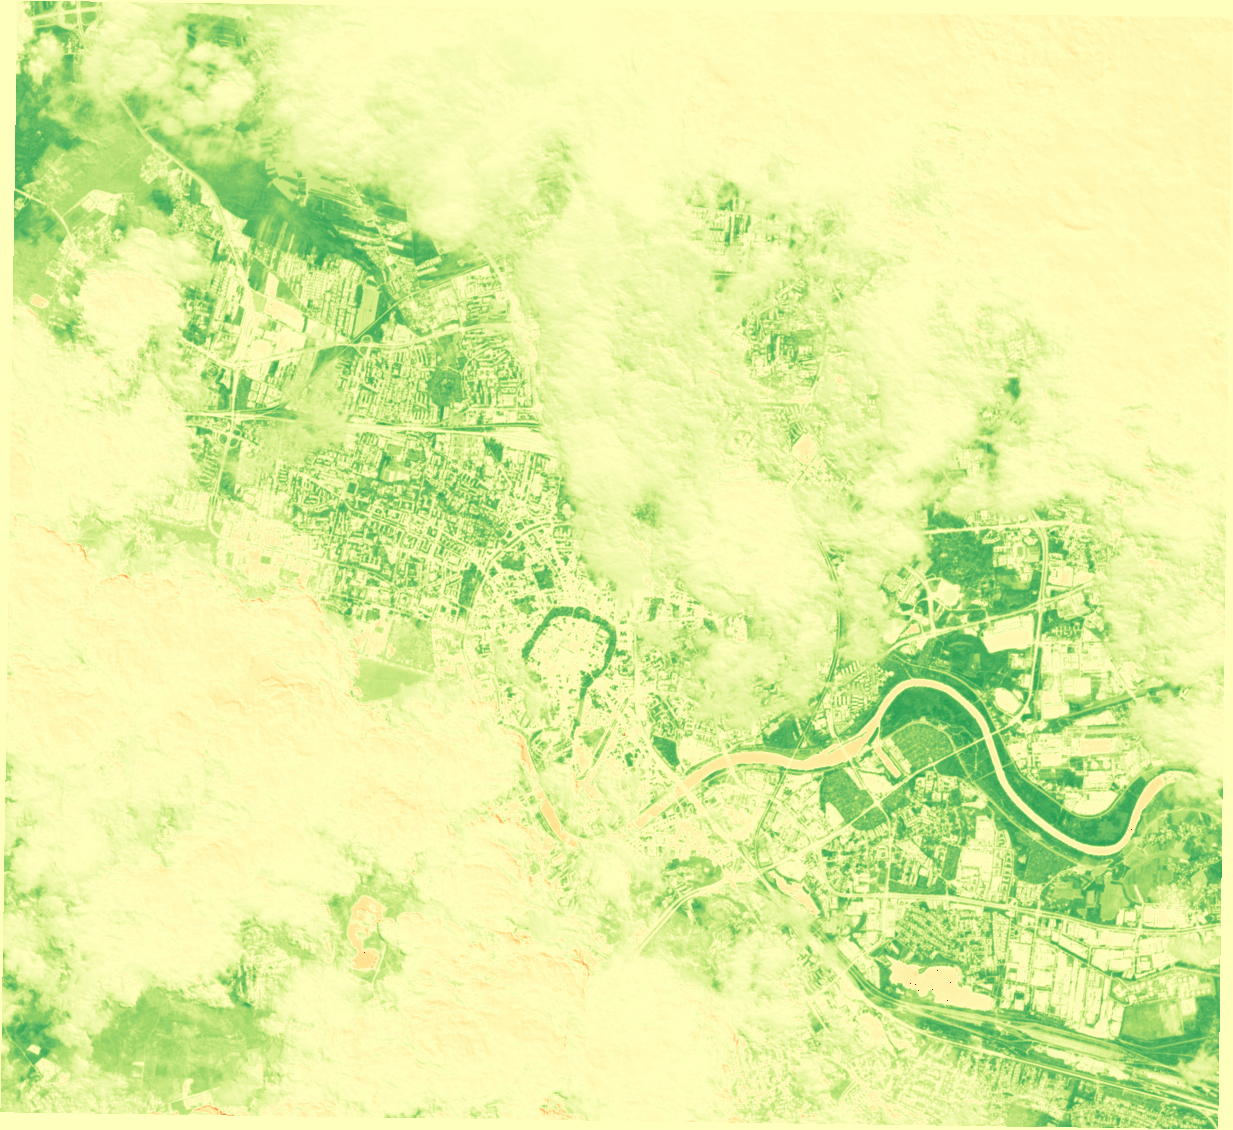

In [7]:
# Tworzenie mapy i dodanie NDVI jako warstwy rastrowej
minx, miny, maxx, maxy = bounds
m = folium.Map(location=[(miny + maxy) / 2, (minx + maxx) / 2], zoom_start=10)
image_overlay = ImageOverlay(
    image=image_url,
    bounds=[[miny, minx], [maxy, maxx]],
    opacity=0.6,
    name="NDVI Layer"
)
image_overlay.add_to(m)

# Dodanie opcji sterowania warstwami
folium.LayerControl().add_to(m)

# Wyświetlenie mapy
m
